In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

### Solar power generation data for one plant gathered at 15 minutes intervals over a 34 day period.


In [2]:
plantOneGen = pd.read_csv('data/Plant_1_Generation_Data.csv')
display(plantOneGen.head())
plantOneGen.info()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


## None of the inverters seem to have the same number of records...

### Not sure if this is caused by inverters going offline for some reason or if there could be missing data.  Going to plot a couple stations joined to a full list of dates and see if there is any obvious trends in the missing values.

In [3]:
display(plantOneGen.SOURCE_KEY.value_counts())

print(plantOneGen.DATE_TIME.min())
print(plantOneGen.DATE_TIME.max())

dates = pd.date_range(plantOneGen.DATE_TIME.min(), plantOneGen.DATE_TIME.max(), freq='15MIN')
print('Number of records there should be for continuous records at 15 min intervals: ',len(dates))

bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
VHMLBKoKgIrUVDU    3133
7JYdWkrLSPkdwr4    3133
ih0vzX44oOqAx2f    3130
ZnxXDlPa8U1GXgE    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
zVJPv84UY57bAof    3124
sjndEbLyjtCKgGv    3124
rGa61gmuvPhdLxV    3124
McdE0feGgRqW7Ca    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
1IF53ai7Xc0U56Y    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64

01-06-2020 00:00
31-05-2020 23:45
Number of records there should be for continuous records at 15 min intervals:  14112


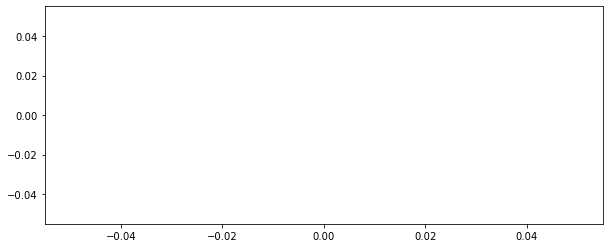

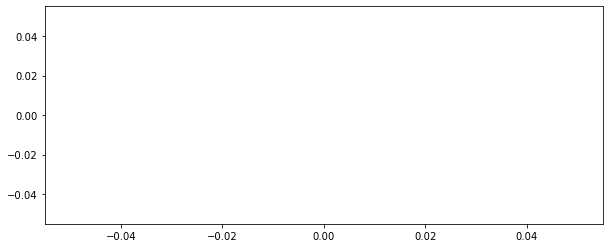

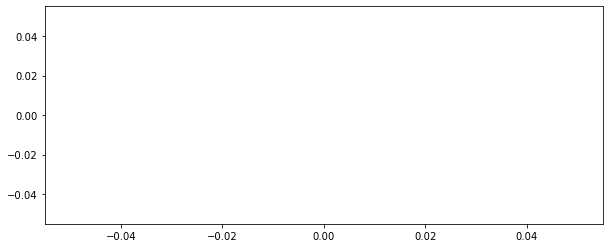

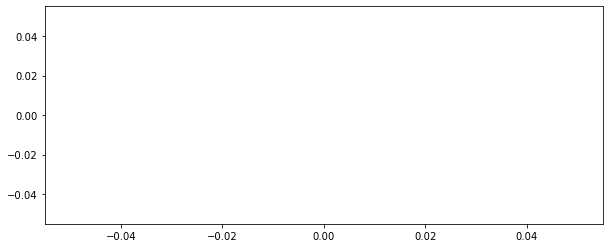

In [4]:
import time 
import datetime

datesDf = pd.DataFrame(index=dates)

values = plantOneGen.SOURCE_KEY.value_counts()

loop = [0,1,-2,-1]

def color(d):
    if pd.isna(d):
        return 100
    return 1

for i in loop: # get top and botom two values for plotting
    key = values.index[i]
    data = pd.DataFrame(plantOneGen.loc[plantOneGen.SOURCE_KEY == key, ['DATE_TIME','DC_POWER']])
    data.DATE_TIME = pd.to_datetime(data.DATE_TIME)
    full = datesDf.join(data, how='left')
    full['color'] = full.DC_POWER.apply(color)
    full.DC_POWER.fillna(method='ffill', inplace=True)
    full.reset_index(drop=False, inplace=True)
    full.DATE_TIME = [pd.Timestamp(i) for i in  full.DATE_TIME]

    plt.figure(figsize=(10,4))
    sns.scatterplot(x=full.index, y=full.DC_POWER, hue=full.color, style=full.color, size=full.color, palette='dark')

    plt.show()


### Weather sensor data gathered for one solar plant every 15 minutes over a 34 days period.

In [5]:
plantOneSensor = pd.read_csv('data/Plant_1_Weather_Sensor_Data.csv')
display(plantOneSensor.head())
plantOneSensor.info()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [6]:
# Look at the vlues in the SOURCE_KEY for plant1 = this is the inverter ID - measurements are at the inverter level - each inverter has multiple lines of solar pannels connected to it 
# Inverter changes DC -> AC; allows the power to be either directly used or fed into the grid - there might be a pretty easy way to identify faulty inverters based off their converstion rate from DC -> AC.

display(pd.DataFrame(plantOneGen.SOURCE_KEY.value_counts().head()))
print('Number of Inverters at Plant 1: {}'.format(len(plantOneGen.SOURCE_KEY.value_counts().index)))

,SOURCE_KEY
bvBOhCH3iADSZry,3155
1BY6WEcLGh8j5v7,3154
VHMLBKoKgIrUVDU,3133
7JYdWkrLSPkdwr4,3133
ih0vzX44oOqAx2f,3130


Number of Inverters at Plant 1: 22


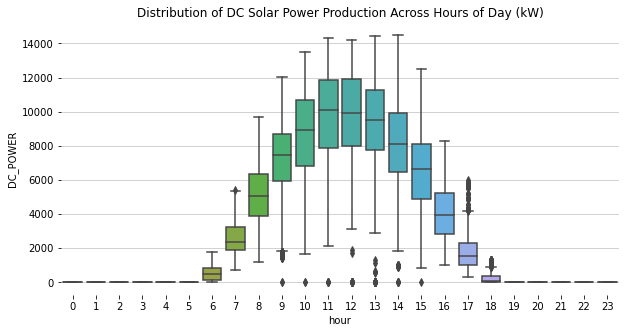

In [7]:
# quickly look at the general daily trend across all inverters at plant1

plantOneGen.DATE_TIME = pd.to_datetime(plantOneGen.DATE_TIME,format="%d-%m-%Y %H:%M")
plantOneGen['hour'] = plantOneGen.DATE_TIME.dt.hour
plt.figure(figsize=(10,5))
sns.boxplot(plantOneGen.hour, plantOneGen.DC_POWER)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.title('Distribution of DC Solar Power Production Across Hours of Day (kW)')
plt.show()

In [8]:
# see if there are any obvious outliers for the conversion rate to AC - just look at the average conversion rate when there is power being produced

plantOneGen['convRate'] = plantOneGen.AC_POWER / plantOneGen.DC_POWER # 
plantOneGen['convRate'].fillna(0, inplace=True)

withPower = plantOneGen.loc[plantOneGen.DC_POWER > 0,:]

grouped = withPower.groupby('SOURCE_KEY')

invGrouped = pd.DataFrame(grouped.convRate.mean())
invGrouped['std'] = grouped.convRate.std()
invGrouped = invGrouped.sort_values('std', ascending=False)
display(invGrouped.head())
invGrouped.tail()

,convRate,std
SOURCE_KEY,,
McdE0feGgRqW7Ca,0.097719,0.000504
sjndEbLyjtCKgGv,0.097725,0.000501
bvBOhCH3iADSZry,0.097733,0.000474
1BY6WEcLGh8j5v7,0.097729,0.000471
z9Y9gH1T5YWrNuG,0.097718,0.000462


,convRate,std
SOURCE_KEY,,
uHbuxQJl8lW7ozc,0.097716,0.000445
ZoEaEvLYb1n2sOq,0.097717,0.000444
pkci93gMrogZuBj,0.097718,0.000443
WRmjgnKYAwPKWDb,0.097718,0.000442
3PZuoBAID5Wc2HD,0.097714,0.000441


# Something seems off with the convRate here - my research shows DC -> AC conversion is much close to 100% conversion rate than 10% like is shown here.  Plot it a few more times to see what is going on.  

## Revisit this later in notebook - looks like the conversion rate here is off by one order of magnitude.  Doesn't seem to be a conversion issue because the closest common units are 3 orders of magnitude away.... Not sure what is going on here with the data.  More analysis later in notebook when comparing against plant 2

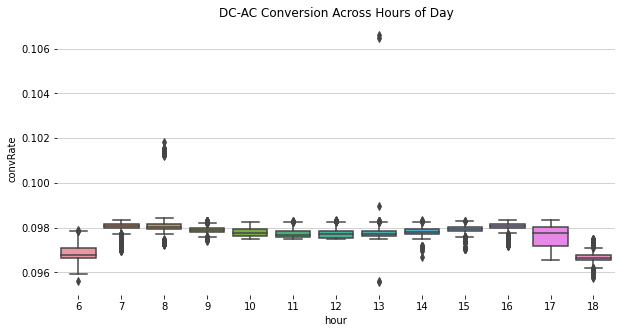

In [9]:

plt.figure(figsize=(10,5))
sns.boxplot(withPower.hour, withPower.convRate)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.title('DC-AC Conversion Across Hours of Day')
plt.show()

In [10]:
# join the data together to bring in some temperature data into exploratory analysis 

plantOneGen.set_index(pd.DatetimeIndex(plantOneGen['DATE_TIME']), inplace=True)
plantOneSensor.DATE_TIME = pd.to_datetime(plantOneSensor.DATE_TIME)
plantOneSensor.set_index(pd.DatetimeIndex(plantOneSensor['DATE_TIME']), inplace=True)

plantOneSensorJoin = plantOneSensor[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']]

plantOneFull = pd.merge(plantOneGen, plantOneSensorJoin, how='left', right_index=True, left_index=True)

plantOneFull.head()


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,hour,convRate,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,,,,,
2020-05-15,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,0,0.0,25.184316,22.857507,0.0


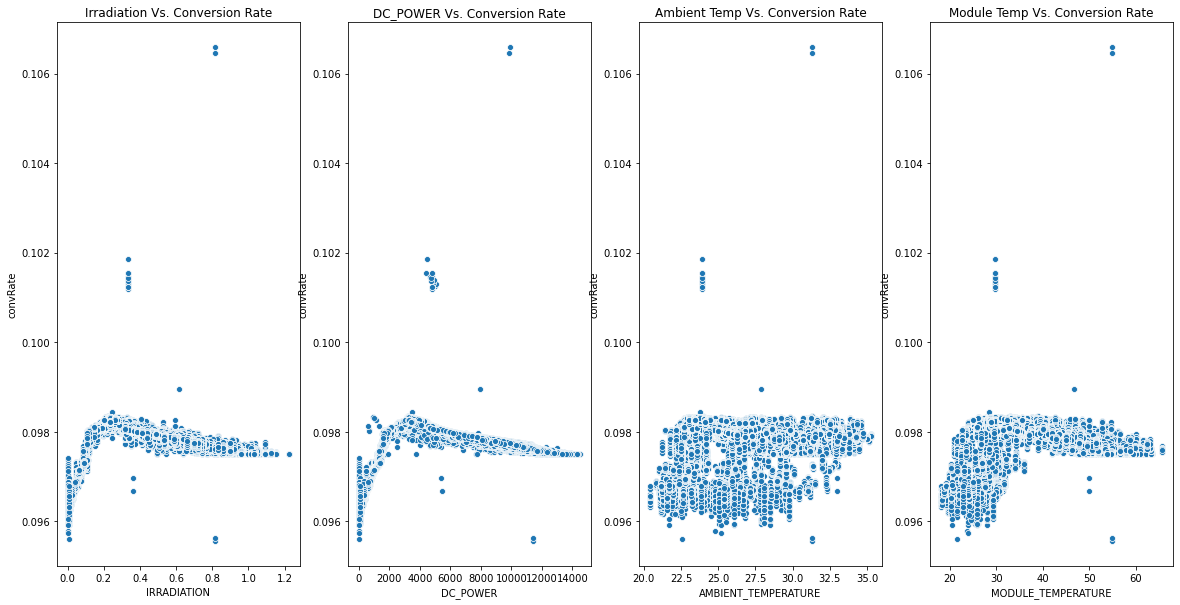

In [11]:

f , (a1, a2, a3, a4) = plt.subplots(nrows=1, ncols=4, figsize=(20,10))


sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].IRRADIATION,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a1)
a1.set_title('Irradiation Vs. Conversion Rate')

sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].DC_POWER,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a2)
a2.set_title('DC_POWER Vs. Conversion Rate')

sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].AMBIENT_TEMPERATURE,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a3)
a3.set_title('Ambient Temp Vs. Conversion Rate')

sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].MODULE_TEMPERATURE,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a4)
a4.set_title('Module Temp Vs. Conversion Rate')

plt.show()

# Look to see if there is a relatively simple way to see when an array of pannels could use cleaning 

### Going to start with a simple OLS fit on the intire data set to look at the relationship between irradiation and DC power.  Seems like an obvious way to identify if an array is dirty or if an inverter (or other tech in line) is faulty or beginning to fail.


##### Going to look at how well the model describes the overall data set - then with each individual array/ inverter, I will compare some values around the distribution of the residuals of the overall OLS and an OLS model fit for each array/ inverter.  Planning to look at the coeffecient for the irradiation variable, distribution of the residuals, and the explained variance within the model (R2).

No handles with labels found to put in legend.
No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 3.190e+06
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:04:47   Log-Likelihood:            -5.3595e+05
No. Observations:               68774   AIC:                         1.072e+06
Df Residuals:                   68772   BIC:                         1.072e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.6641      2.821     26.465      0.0

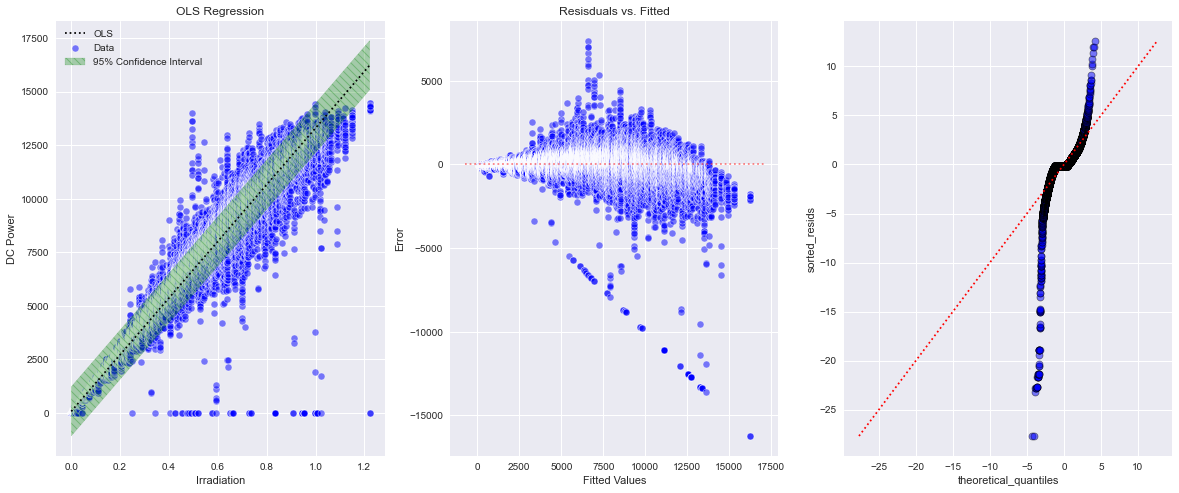

In [63]:
plantOneTemp = pd.DataFrame(plantOneFull.dropna())
plantOneTemp.sort_values('IRRADIATION', ascending=True, inplace=True)

#statsmodels ols gives great summary stats

plantOneTemp['x1'] = plantOneTemp.IRRADIATION.copy()
plantOneTemp['y'] = plantOneTemp.DC_POWER.copy()

results = smf.ols('y ~ x1', data=plantOneTemp).fit()
p, lower, upper = wls_prediction_std(results)
fitLine = results.fittedvalues

plantOneTemp['yhat'] = fitLine
plantOneTemp['residuals'] = plantOneTemp.y - plantOneTemp.yhat

#show ols results
print(results.summary())


sorted_resids = pd.Series(results.get_influence().resid_studentized_internal)
sorted_resids.index = results.resid.index
sorted_resids.sort_values(ascending=True, inplace=True)
df = pd.DataFrame(sorted_resids)
df.columns = ['sorted_resids']
df['theoretical_quantiles'] = stats.probplot(df['sorted_resids'], dist='norm', fit=False)[0]

f, a = plt.subplots(ncols=3, nrows=1, figsize=(20,8))

# plot the fit line and confidence interval
sns.scatterplot(plantOneTemp.x1, plantOneTemp.y, alpha=0.5, color='blue',label='Data', ax=a[0])
a[0].fill_between(plantOneTemp.x1, lower, upper,color='g',
                 hatch='\\\\\\', alpha=0.3, 
                 label='95% Confidence Interval' )
a[0].plot(plantOneTemp.x1, fitLine, color='k', linestyle=':', label='OLS')
a[0].set_title('OLS Regression')
a[0].set_xlabel('Irradiation')
a[0].set_ylabel('DC Power')
a[0].legend()


# plot the residuals over the predicted values
sns.scatterplot(plantOneTemp.yhat, plantOneTemp.residuals, color='blue', alpha=0.5, ax=a[1])
a[1].hlines(0,a[1].get_xlim()[0], a[1].get_xlim()[1],  # get bottom and top lims for the line 
           color='r', alpha=0.5, linestyle=':') 
a[1].set_title('Resisduals vs. Fitted')
a[1].set_xlabel('Fitted Values')
a[1].set_ylabel('Error')
a[1].legend()



#plot the "Normal Q-Q" chart - 
sns.scatterplot(df.theoretical_quantiles, df.sorted_resids, color='blue', alpha=0.5, edgecolor='k', ax=a[2])
a[2].plot([np.min([df.theoretical_quantiles, df.sorted_resids]),np.max([df.theoretical_quantiles, df.sorted_resids])],
         [np.min([df.theoretical_quantiles, df.sorted_resids]),np.max([df.theoretical_quantiles, df.sorted_resids])],
         color='r', linestyle=':')


plt.legend()
plt.show()







# Plotting the 95% confidence interval for the OLS regression fit for the relationship between Sensor Irradiation readings and DC power output.
#### It seems that if the slope for the OLS line fit to the scatter data for each inverter is less than 13000, then it falls outside of the norm and may indicate that some pannels in the array need cleaning, or that there are faults in the system somewhere.
#### A more elaborate method would be to get the readings for each array when they're guarenteed to be clean - then base the change off that inverter's conversion rate from Irradiation to DC power.  This is due to the fact that there is only one sensor per power plant, and there may be shadows or other environmental factors that change what the average conversion rate (slope) would be for each individual sensor.

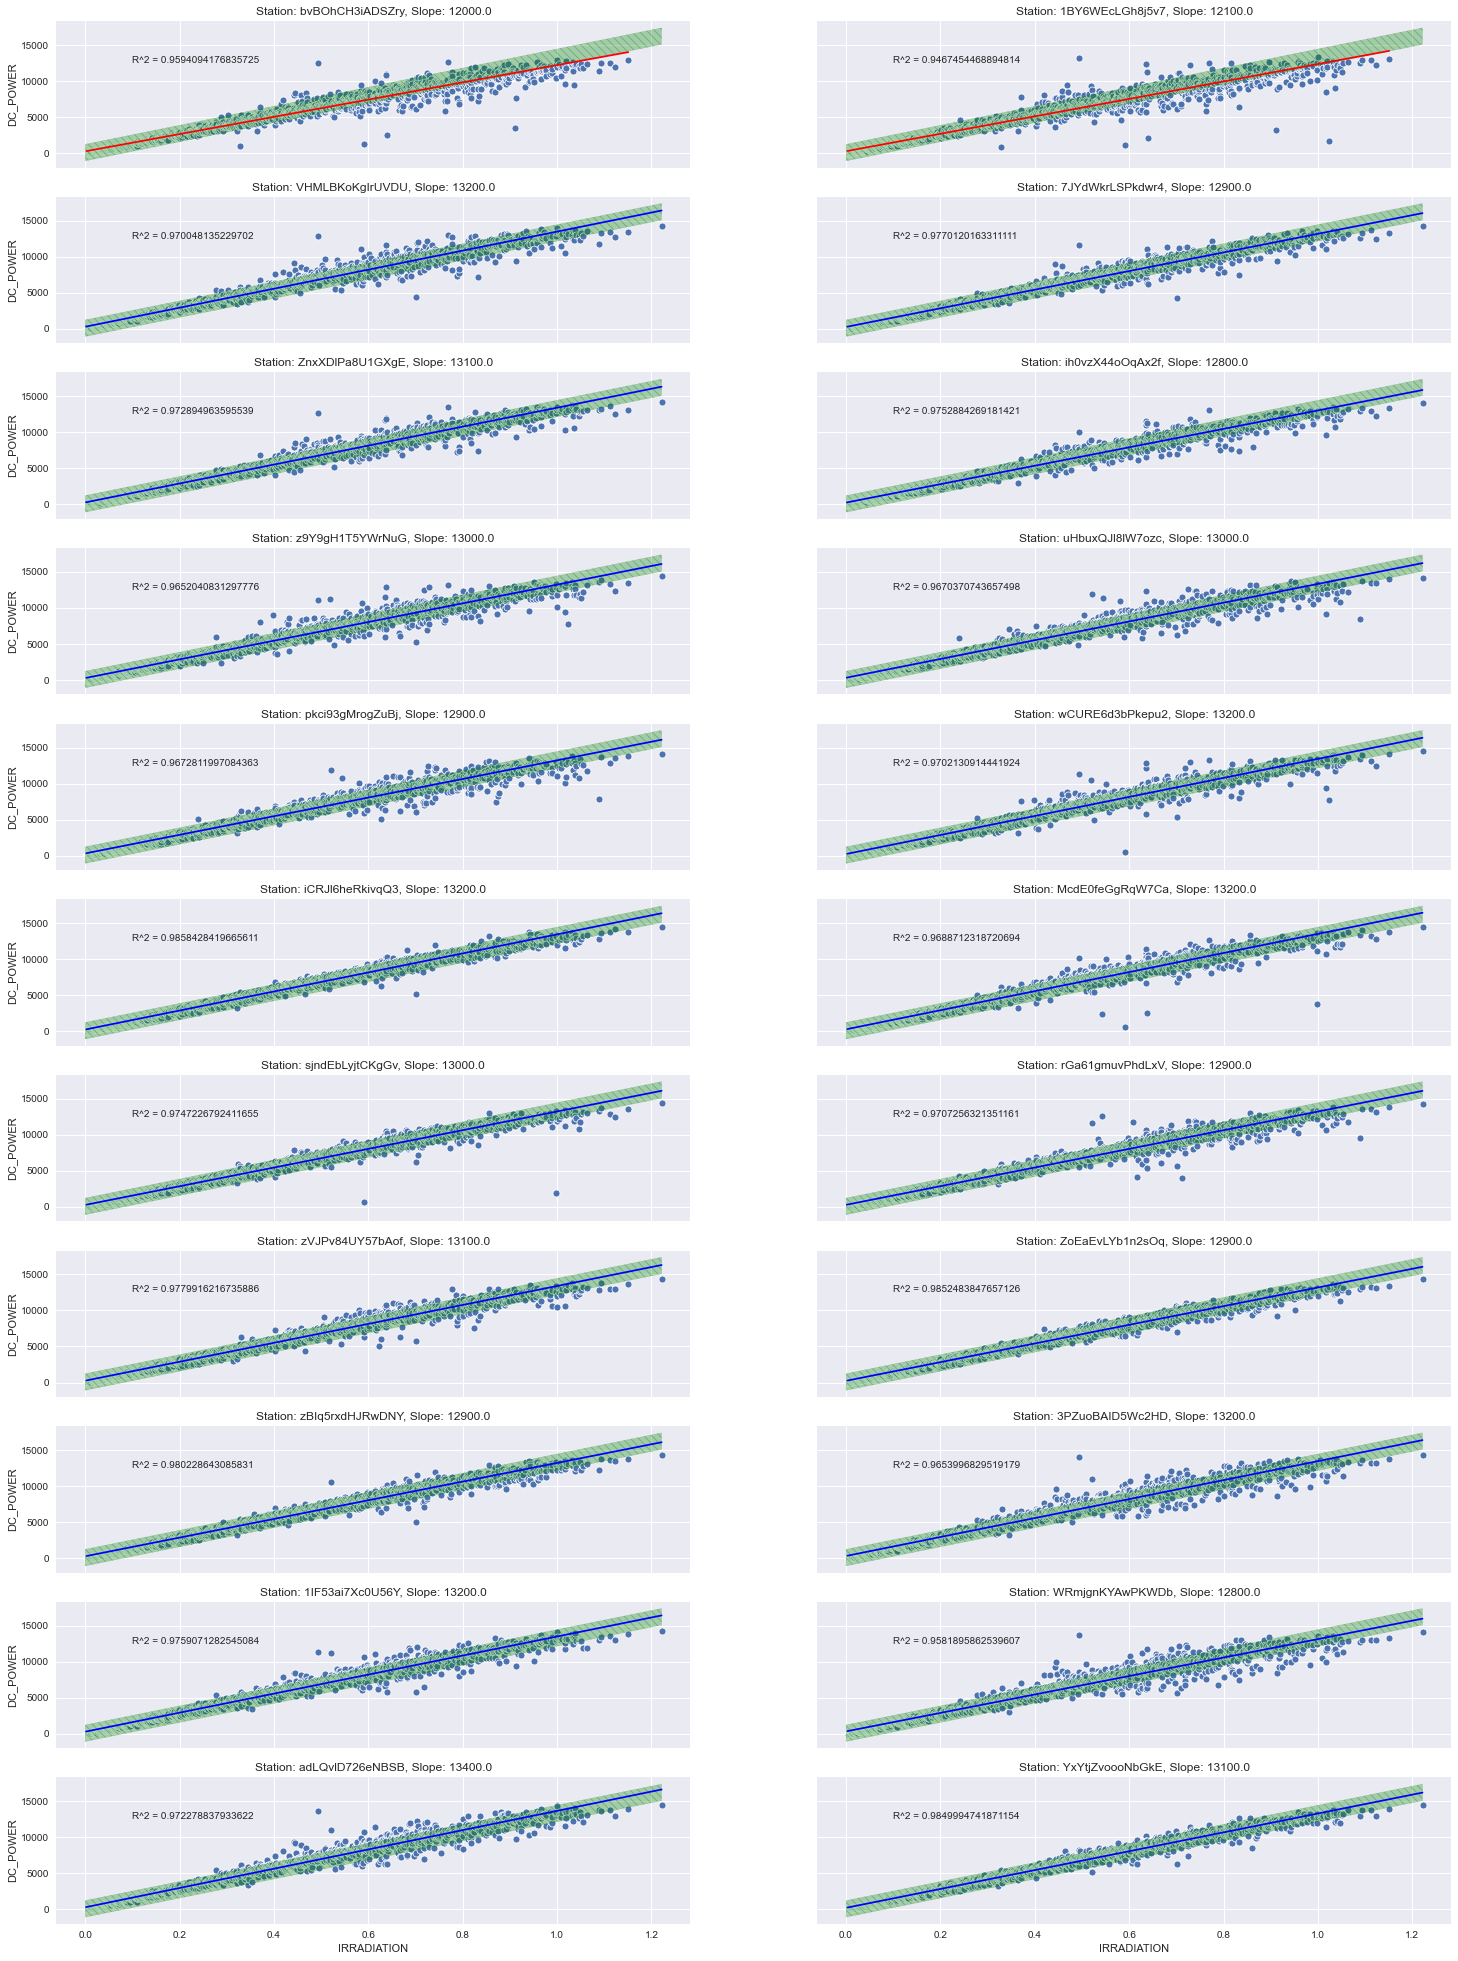

In [29]:
# lets look at the relationship between irradiation and dc power to see if there are any sections of solar pannels that could use some cleaning 
# using dc power rather than AC to not factor in potential poor inverters 


def line(slope, intercept, x):
    result = intercept + np.multiply(slope, x)
    return result

# build a dictionary in order to store the stations regression values
stations ={}

#gerneal relationship across all stations


f, a = plt.subplots(nrows=11, ncols=2, figsize = (25,35),sharex=True, sharey=True)

a = a.ravel() 
counter = 0



for key in plantOneTemp.SOURCE_KEY.value_counts().index: # loop through the inverters
    axx = a[counter] # get our axis
    data = plantOneTemp.loc[plantOneTemp.SOURCE_KEY == key,['IRRADIATION','DC_POWER']]
    data = data.loc[data.DC_POWER != 0]
    slope, intercept, r, p, std_err = stats.linregress(data.IRRADIATION, data.DC_POWER)
    stations[key] = {'m':slope,
                    'b':intercept,
                    'r':r**2,
                    'p':p,
                    'std':std_err} 
    data['line'] = line(slope, intercept, data.IRRADIATION.values)
    if round(slope/1000, 0) * 1000 < 13000:
        color = 'red'
    else:
        color = 'blue'
    
    sns.lineplot(data=data, x='IRRADIATION', y='line', color=color, ax=axx)
    sns.scatterplot(data=data, x='IRRADIATION', y='DC_POWER', ax=axx)
    axx.fill_between(plantOneTemp.IRRADIATION, upper.ravel(), lower.ravel(), color='g', hatch='\\\\\\', alpha=0.3, label='95% Confidence Interval From Overall Fit')
    axx.text(0.1,12500,'R^2 = {}'.format(r**2))
    axx.set_title('Station: {}, Slope: {}'.format(key, round(slope/100, 0) * 100))
    counter += 1
plt.show()    

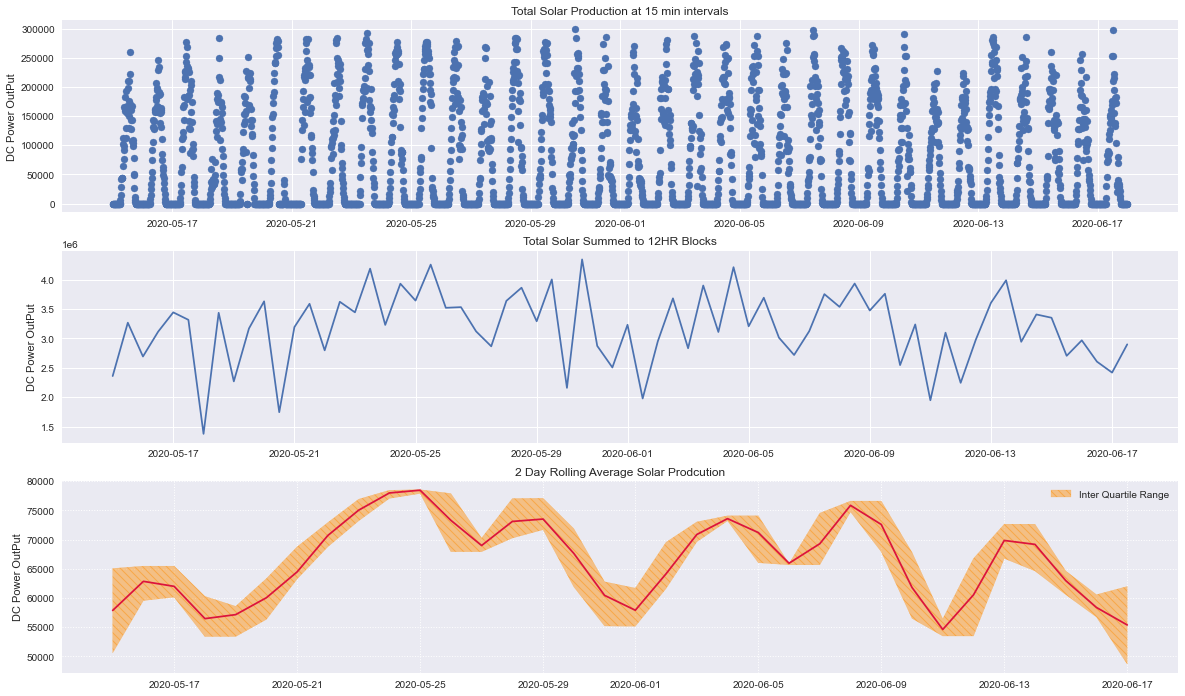

In [13]:
plt.style.use('seaborn')

plotdf = plantOneFull.loc[:,['DC_POWER']]

plotdf = plotdf.groupby(plotdf.index).sum().resample('15Min').sum()






season = plotdf.rolling(window=2*4*24, center=True, min_periods=20).mean().groupby(plotdf.index.dayofyear).mean()


q25 = plotdf.rolling(window=2*4*24, center=True, min_periods=20).mean().groupby(plotdf.index.dayofyear).quantile(.25)
q75 = plotdf.rolling(window=2*4*24, center=True, min_periods=20).mean().groupby(plotdf.index.dayofyear).quantile(.75)



endDates = (np.asarray(2020, dtype='datetime64[Y]')-1970)+(np.asarray(season.index, dtype='timedelta64[D]')-1)

dates = pd.to_datetime(endDates).strftime('%B %d')


f, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20,12))



ax1.scatter(plotdf.index, plotdf.DC_POWER)
ax1.set_ylabel('DC Power OutPut')
ax1.set_title('Total Solar Production at 15 min intervals')



fullplotdf = plotdf.resample('12H').sum()

ax2.plot(fullplotdf.index, fullplotdf.DC_POWER)
ax2.set_ylabel('DC Power OutPut')
ax2.set_title('Total Solar Summed to 12HR Blocks')

ax3.fill_between(endDates,q25.values.ravel(),q75.values.ravel(),color='#FF8C00',hatch='\\\\\\', alpha=0.45, label='Inter Quartile Range')
ax3.plot(endDates, season.DC_POWER, color='#DC143C')




ax3.set_ylabel('DC Power OutPut')
ax3.set_title('2 Day Rolling Average Solar Prodcution')

    
ax3.set_xlabel('')

ax3.grid(ls=':')

ax3.legend()

plt.show()

In [14]:
plantOneFull.columns

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD', 'hour', 'convRate', 'AMBIENT_TEMPERATURE',
       'MODULE_TEMPERATURE', 'IRRADIATION'],
      dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3192D5BC8>,
      dtype=object)

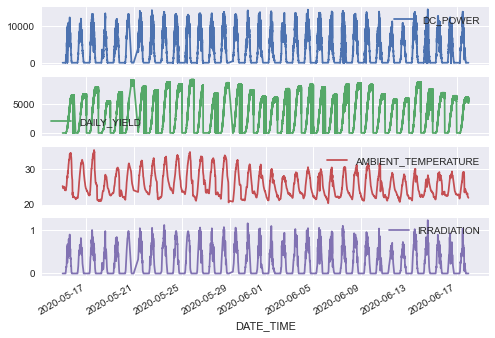

In [15]:
plot_cols = ['DC_POWER', 'DAILY_YIELD','AMBIENT_TEMPERATURE', 'IRRADIATION']
plot_features = plantOneFull[plot_cols]
plot_features.plot(subplots=True)

# Now Looking into Plant Two


#### Wanting to look into each plant indivudually - look at a few general trends in each plant and then compare the trends - particularly around total power generation/ conversion rate from DC -> AC power - something seems off with the converion rate in the first data set.  Still need to hypothesise a way to 'fix' that data before moving into building forecasts 

In [16]:
plantTwoGen = pd.read_csv('data/Plant_2_Generation_Data.csv')
display(plantTwoGen.head())
plantTwoGen.info()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB


In [17]:
print(plantTwoGen.SOURCE_KEY.value_counts())
len(plantTwoGen.SOURCE_KEY.value_counts())

9kRcWv60rDACzjR    3259
WcxssY2VbP4hApt    3259
LYwnQax7tkwH5Cb    3259
81aHJ1q11NBPMrL    3259
rrq4fwE8jgrTyWY    3259
PeE6FRyGXUgsRhN    3259
xoJJ8DcxJEcupym    3259
LlT2YUhhzqhg5Sw    3259
q49J1IKaHRwDQnt    3259
vOuJvMaM2sgwLmb    3259
V94E5Ben1TlhnDV    3259
oZZkBaNadn6DNKz    3259
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6    3195
oZ35aAeoifZaQzV    3195
Quc1TzYxW2pYoWX    3195
Mx2yZCDsyf6DPfv    3195
Et9kgGMDl729KT4    3195
NgDl19wMapZy17u    2355
IQ2d7wF4YD8zU1Q    2355
mqwcsP2rE7J0TFp    2355
xMbIugepa2P7lBB    2355
Name: SOURCE_KEY, dtype: int64


22

In [22]:
plantTwoGen.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,hour
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04,67698.000000
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08,11.530208
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08,6.922127
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07,6.000000
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08,12.000000
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09,18.000000
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09,23.000000


In [23]:
plantTwoGen.DATE_TIME = pd.to_datetime(plantTwoGen.DATE_TIME)

plantTwoGen['hour'] = plantTwoGen.DATE_TIME.dt.hour

plantTwoGen['convRate'] = plantTwoGen.AC_POWER / plantTwoGen.DC_POWER

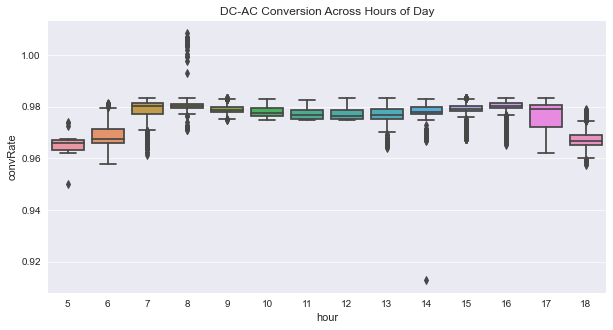

In [24]:

withPower2 = plantTwoGen.loc[plantTwoGen.DC_POWER > 0]

plt.figure(figsize=(10,5))
sns.boxplot(withPower2.hour, withPower2.convRate)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.title('DC-AC Conversion Across Hours of Day')
plt.show()

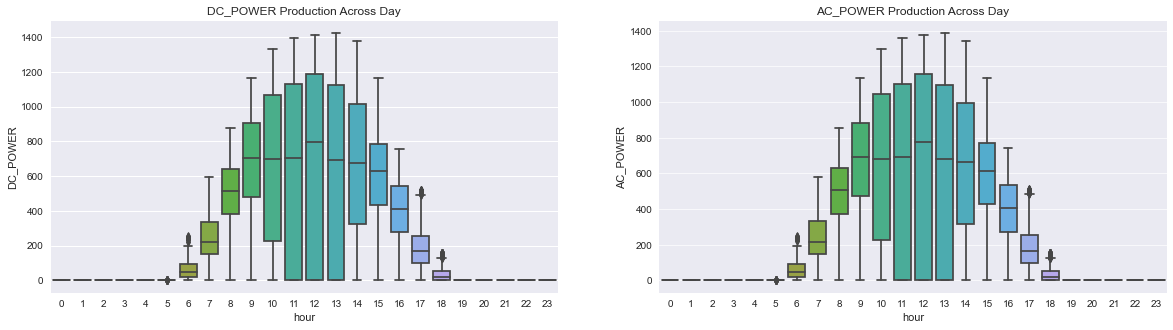

In [25]:
f, (a, a2) = plt.subplots(ncols=2, nrows=1, figsize=(20,5))

sns.boxplot(plantTwoGen.hour, plantTwoGen.DC_POWER, ax=a)
a.set_title('DC_POWER Production Across Day')


sns.boxplot(plantTwoGen.hour, plantTwoGen.AC_POWER, ax=a2)
a2.set_title('AC_POWER Production Across Day')



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.show()

# Why is the iqr so large in the middle hours of the day - when we'd expect a solar array to be generating the most electricity?

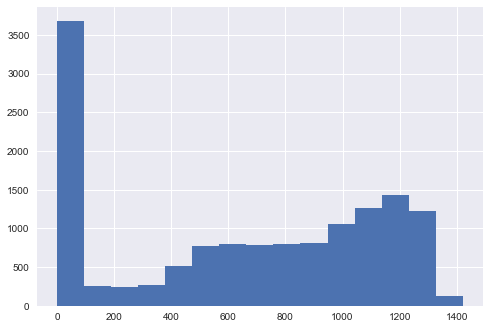

In [26]:
midDay = plantTwoGen.loc[(plantTwoGen.hour >= 10) & (plantTwoGen.hour <= 14), :]

# quicly look at the distribution of production values in the mid day hours

plt.hist(midDay.DC_POWER.values, bins=15)
plt.show()

In [27]:
print(midDay.loc[midDay.DC_POWER == 0].SOURCE_KEY.value_counts())
print(len(midDay.loc[midDay.DC_POWER == 0].SOURCE_KEY.value_counts()))
# looks like all the stations have at least a few values without any power generation during the mid day hours

LYwnQax7tkwH5Cb    304
Et9kgGMDl729KT4    269
rrq4fwE8jgrTyWY    252
Quc1TzYxW2pYoWX    241
q49J1IKaHRwDQnt    228
81aHJ1q11NBPMrL    197
9kRcWv60rDACzjR    196
xoJJ8DcxJEcupym    190
LlT2YUhhzqhg5Sw    189
oZZkBaNadn6DNKz    172
PeE6FRyGXUgsRhN    168
WcxssY2VbP4hApt    167
V94E5Ben1TlhnDV    158
vOuJvMaM2sgwLmb    150
oZ35aAeoifZaQzV    127
4UPUqMRk7TRMgml    116
Qf4GUc1pJu5T6c6    111
Mx2yZCDsyf6DPfv    100
NgDl19wMapZy17u     32
mqwcsP2rE7J0TFp     27
IQ2d7wF4YD8zU1Q     21
xMbIugepa2P7lBB     21
Name: SOURCE_KEY, dtype: int64
22


In [28]:
midDay['date'] = midDay.DATE_TIME.dt.strftime('%Y-%m-%d')

midDay.loc[midDay.DC_POWER == 0].date.value_counts

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<bound method IndexOpsMixin.value_counts of 881      2020-05-15
883      2020-05-15
891      2020-05-15
901      2020-05-15
902      2020-05-15
            ...    
64767    2020-06-16
64768    2020-06-16
64769    2020-06-16
64770    2020-06-16
64771    2020-06-16
Name: date, Length: 3436, dtype: object>